In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from scipy.spatial.transform import Rotation as R



In [40]:
base_x = 0.295
base_y = 0.414

shoulder_z = 1.193
cardboard_z = 0.827
base_to_shoulder_y = 0.304
gripper_y = 0.99
shoulder_y = 0.4735
arm_length = gripper_y - shoulder_y
cardboard_to_shoulder_z = shoulder_z - cardboard_z
shoulder_to_grippper_y = np.sqrt(arm_length**2 - cardboard_to_shoulder_z**2)
farthest_dist = base_to_shoulder_y + shoulder_to_grippper_y

max_angle = np.rad2deg(np.arcsin(cardboard_to_shoulder_z/arm_length))

rect_center_x = -0.0235
rect_center_y = 0.9845
rect_offset = 0.05
rect_w = 0.272*2 - rect_offset*2
rect_h = 0.1785*2 - rect_offset*2

nearest_x = rect_center_x + rect_w/2
nearest_y = rect_center_y - rect_h/2

nearest_dist = np.linalg.norm(np.array([base_x, base_y]) - np.array([nearest_x, nearest_y]))


bucket_height = 0.11
bucket_z = cardboard_z + bucket_height
bucket_to_shoulder_z = shoulder_z - bucket_z
shoulder_to_grippper_y_bucket = np.sqrt(arm_length**2 - bucket_to_shoulder_z**2)
farthest_dist_bucket = base_to_shoulder_y + shoulder_to_grippper_y_bucket

nearest_dist, farthest_dist, max_angle, farthest_dist_bucket

(0.45241159357381644,
 0.6684396383490685,
 45.12239478312595,
 0.7525936357105392)

In [38]:
farthest_dist

0.6684396383490685

In [3]:
def sample_obj_and_dst_pose(mobile=False):
    if not mobile:
        obj_x_range = [-0.1, 0.3]
        dst_x_range = [-0.1, 0.3]
        y_range = [0.3, 0.8]
        obj_z_range = [0.015, 0.015]
        dst_z_range = [0.015, 0.015]
        obj_angle_range = [0, 180]
        obj_dst_interval = 0.1    
    # else:
    #     obj_x_range = [0.0355, 0.0355]
    #     dst_x_range = [-0.2385, -0.2385] # -0.2385, 0.1915
    #     y_range = [0.863, 0.863] # 0.863, 1.106
    #     obj_z_range = [0.842, 0.842]
    #     dst_z_range = [0.827, 0.827]
    #     obj_angle_range = [0, 0] # -90, 90
    #     obj_dst_interval = 0.1            

        obj_ranges = np.vstack([obj_x_range, y_range, obj_z_range])
        obj_position = np.random.uniform(obj_ranges[:, 0], obj_ranges[:, 1])
        obj_angle = np.random.uniform(obj_angle_range[0], obj_angle_range[1])    
        obj_quat = np.array([np.cos(np.deg2rad(obj_angle)/2), 0, 0, np.sin(np.deg2rad(obj_angle)/2)])    
        dst_ranges = np.vstack([dst_x_range, y_range, dst_z_range])
        dst_position = np.random.uniform(dst_ranges[:, 0], dst_ranges[:, 1])

        while np.linalg.norm(dst_position[:2] - obj_position[:2]) < 0.055+0.002+obj_dst_interval:
            dst_position = np.random.uniform(dst_ranges[:, 0], dst_ranges[:, 1])
    
    else:
        circle_x = 0.295
        circle_y = 0.414
        obj_circle_r = 0.6684396383490685
        dst_circle_r = 0.6684396383490685

        rect_center_x = -0.0235
        rect_center_y = 0.9845
        rect_offset = 0.05
        rect_w = 0.272*2 - rect_offset*2
        rect_h = 0.1785*2 - rect_offset*2

        obj_z = 0.842
        dst_z = 0.827
        obj_angle_range = [-90, 90] # -90, 90
        obj_dst_interval = 0.1            
        obj_xy = hit_or_miss_sample(obj_circle_r, circle_x, circle_y, rect_center_x, rect_center_y, rect_w, rect_h)
        dst_xy = hit_or_miss_sample(dst_circle_r, circle_x, circle_y, rect_center_x, rect_center_y, rect_w, rect_h)

        obj_angle = np.random.uniform(obj_angle_range[0], obj_angle_range[1])    
        print (obj_angle)
        obj_quat = np.array([np.cos(np.deg2rad(obj_angle)/2), 0, 0, np.sin(np.deg2rad(obj_angle)/2)])    
        print (obj_quat)

        while np.linalg.norm(dst_xy - obj_xy) < 0.055+0.002+obj_dst_interval:
            obj_xy = hit_or_miss_sample(obj_circle_r, circle_x, circle_y, rect_center_x, rect_center_y, rect_w, rect_h)
            dst_xy = hit_or_miss_sample(dst_circle_r, circle_x, circle_y, rect_center_x, rect_center_y, rect_w, rect_h)
        
        obj_position = np.hstack([obj_xy, obj_z])
        dst_position = np.hstack([dst_xy, dst_z])

    dst_quat = np.array([1, 0, 0, 0])
    return np.concatenate([obj_position, obj_quat, dst_position, dst_quat])


def hit_or_miss_sample(circle_r, circle_x, circle_y, rect_center_x, rect_center_y, rect_w, rect_h):
    rect_min_x = rect_center_x-rect_w/2
    rect_max_x = rect_center_x+rect_w/2
    rect_min_y = rect_center_y-rect_h/2
    rect_max_y = rect_center_y+rect_h/2
    
    min_x = min(circle_x-circle_r, rect_min_x)
    max_x = max(circle_x+circle_r, rect_max_x)    
    min_y = min(circle_y-circle_r, rect_min_y)
    max_y = max(circle_y+circle_r, rect_max_y)        

    in_rect, in_circle = False, False

    while not (in_rect and in_circle):    
        sample = np.random.uniform(low=[min_x, min_y], high=[max_x, max_y])
        sample_x, sample_y = sample
        
        in_rect = (rect_min_x < sample_x) & (sample_x < rect_max_x) & (rect_min_y < sample_y) & (sample_y < rect_max_y)
        in_circle = np.linalg.norm(sample - np.stack([circle_x, circle_y])) < circle_r

    return sample

def quaternion_to_euler(q):
    r = R.from_quat([q[1], q[2], q[3], q[0]])
    return r.as_euler('xyz', degrees=True)


def interpolate_wrist_angle(object_dist):
    MAX_ANGLE = 90
    MIN_ANGLE = 45.12239478312595
    
    MAX_DIST = 0.9370310024003563
    MIN_DIST = 0.45241159357381644
    
    a = (MIN_ANGLE - MAX_ANGLE)/(MAX_DIST - MIN_DIST)
    b = MAX_ANGLE - a*MIN_DIST

    return a*object_dist + b


In [4]:
MAX_ANGLE = 90
MIN_ANGLE = 45.12239478312595

MAX_DIST = 0.9370310024003563
MIN_DIST = 0.45241159357381644

a = (MIN_ANGLE - MAX_ANGLE)/(MAX_DIST - MIN_DIST)
b = MAX_ANGLE - a*MIN_DIST
b

131.89503870904545

In [5]:
b = MIN_ANGLE - a*MAX_DIST
b

131.89503870904545

In [6]:
object_and_bucket_pose = sample_obj_and_dst_pose(mobile=True)

28.55914571131001
[0.96910373 0.         0.         0.24665352]


In [7]:
q = object_and_bucket_pose[3:7]
q

array([0.96910373, 0.        , 0.        , 0.24665352])

In [20]:
obj_angle = quaternion_to_euler(q)[2]
obj_angle

28.55914571131001

In [21]:
obj_vector = np.array([-np.sin(np.deg2rad(obj_angle)), np.cos(np.deg2rad(obj_angle))])

In [22]:
base_to_obj_vec = object_and_bucket_pose[:2] - np.array([base_x, base_y])

In [26]:
base_angle = np.rad2deg(np.arctan2(*base_to_obj_vec))
-base_angle

17.894553474517423

In [27]:
base_vector = np.array([-np.sin(np.deg2rad(-base_angle)), np.cos(np.deg2rad(-base_angle))])

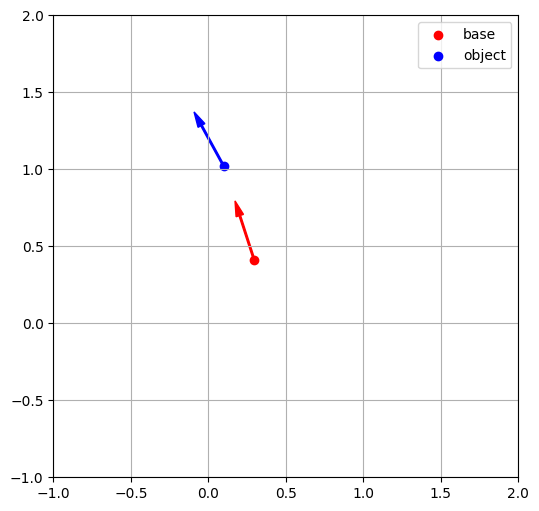

In [28]:
plt.figure(figsize=(6, 6))

plt.scatter(base_x, base_y, c="r", label="base")
plt.scatter(object_and_bucket_pose[0], object_and_bucket_pose[1], c="b", label="object")
scale = 0.4

plt.arrow(x=object_and_bucket_pose[0], y=object_and_bucket_pose[1], 
           dx=obj_vector[0]*scale, 
           dy=obj_vector[1]*scale,
          width=0.01,head_width=0.05,head_length=0.1,length_includes_head=True,color='b')


plt.arrow(x=base_x, y=base_y, 
           dx=base_vector[0]*scale, 
           dy=base_vector[1]*scale,
          width=0.01,head_width=0.05,head_length=0.1,length_includes_head=True,color='r')

plt.xlim(-1, 2)
plt.ylim(-1, 2)

plt.grid()
plt.legend()
plt.show()

In [16]:
0.414

48.55160681269025

In [29]:
0.718 - 0.414


0.304

In [31]:
0.99 - 0.4735

0.5165

In [32]:
0.4735 + 0.5165

0.99

In [39]:
0.414 + farthest_dist

1.0824396383490684

In [42]:
angle = np.pi/4

circle_x = 0.295
circle_y = 0.414

circle_x-farthest_dist*np.cos(angle), circle_y+farthest_dist*np.sin(angle)

(-0.17765820109050978, 0.8866582010905097)

In [43]:
farthest_dist


0.6684396383490685

In [44]:
0.99 - 0.7735

0.21650000000000003

In [45]:
shoulder_to_wrist = 0.3
wrist_to_gripper = 0.2165

In [47]:
shoulder_to_wrist_z = cardboard_to_shoulder_z - wrist_to_gripper
shoulder_to_wrist_z

0.1495000000000001

In [49]:
shoulder_to_wrist_y = np.sqrt(shoulder_to_wrist**2 - shoulder_to_wrist_z**2)

In [50]:
shoulder_to_wrist_y + base_to_shoulder_y

0.564095655480825

In [52]:
np.sqrt(0.3**2 - (0.366 - 0.21)**2) +0.304 + 0.2165

0.7767498780487515